In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [72]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import RidgeClassifier

In [3]:
path = "../../celeba/Intermediate_result/affinity_male_store_preds_part_one.p"
# path = "affinity_sex_store_preds.p"
# path = "affinity_sex_store_latents.p"
with open(path, 'rb') as f:
    data = pickle.load(f)

In [4]:
data.keys()

dict_keys(['name', 'start time', 'attack_config', 'model_names', 'model', 'blackbox', 'whitebox', 'blackbox_vic', 'whitebox_vic', 'save time'])

In [5]:
def hmm(d, key, trial=0, suffix='_vic'):
    bb = d['blackbox' + suffix]
    wb = d['whitebox' + suffix]
    bb_preds, bb_gt = bb[key][trial][1:]
    wb_preds, wb_gt = wb[key][trial]
    
    condition_wb = (wb_preds >= 0) == wb_gt
    condition_bb = (bb_preds >= 0.5) == bb_gt
    
    wb_acc = np.mean(condition_wb)
    bb_acc = np.mean(condition_bb)
    assert np.all(wb_gt == bb_gt)
    print("WB: %.2f, BB: %.2f" % (wb_acc, bb_acc))
    scope = np.mean(1. * np.logical_or(condition_wb, condition_bb))
    print("Scope: %.2f" % scope)
    wb_cond_bb = (1 * condition_bb)[condition_wb]
    bb_cond_wb = (1 * condition_wb)[condition_bb]
    print("P[WB|BB]: %.2f" % np.mean(1. * wb_cond_bb))
    print("P[BB|WB]: %.2f" % np.mean(1. * bb_cond_wb))
    
    return bb_preds, wb_preds, bb_gt

In [6]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

In [7]:
def _expand_if_needed(x_):
    if type(x_) != np.ndarray or  len(x_.shape) == 1:
        return np.expand_dims(x_, axis=1)
    return x_

In [352]:
trial = 0
key = 0.4

In [353]:
bb_vic, wb_vic, y_test = hmm(data, key, trial)
print()
bb_adv, wb_adv, y_train = hmm(data, key, trial, suffix='')

WB: 0.64, BB: 0.54
Scope: 0.87
P[WB|BB]: 0.48
P[BB|WB]: 0.56

WB: 0.81, BB: 0.91
Scope: 0.98
P[WB|BB]: 0.91
P[BB|WB]: 0.81


In [354]:
x_train = np.concatenate(
                (_expand_if_needed(wb_adv), _expand_if_needed(bb_adv)), 1)
x_test = np.concatenate(
                (_expand_if_needed(wb_vic), _expand_if_needed(bb_vic)), 1)

In [365]:
# clf = DecisionTreeClassifier(random_state=0, max_depth=2)
# clf = RandomForestClassifier(max_depth=3, random_state=0)
# clf = SVC(kernel='linear', C=1)
# clf = RidgeClassifier()
# clf = KNeighborsClassifier(n_neighbors=10)
# clf = NearestCentroid()
# clf = MLPClassifier(random_state=1, hidden_layer_sizes=(10, 2, 2), max_iter=700)

In [366]:
# Ignore samples with first feature ~ 0
use = np.logical_and(np.logical_or(x_train[:, 0] < -1, x_train[:, 0] > 1),
                    np.logical_or(x_train[:, 1] > 0.55, x_train[:, 1] < 0.45))
# x_train_ = x_train[use]
# y_train_ = y_train[use]
x_train_, y_train_ = x_train, y_train
clf.fit(x_train_, y_train_)
# clf.fit(x_test, y_test)
print("Tr: %.4f" % clf.score(x_train_, y_train_))
print("Te: %.4f" % clf.score(x_test, y_test))

Tr: 0.9800
Te: 0.5550


In [247]:
# plt.scatter(bb_adv, wb_adv, c=y_train)
def plot_db(X, y):
    fig, ax = plt.subplots()
    # title for the plots
    title = ('Decision surface of linear SVC ')
    # Set-up grid for plotting.
    X0, X1 = X[:, 0], X[:, 1]
    xx, yy = make_meshgrid(X0, X1)

    plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    plt.ylim([0, 1])
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')

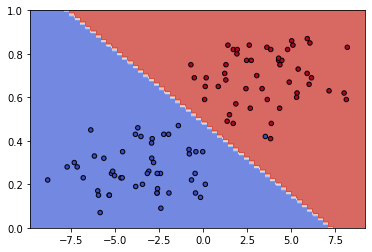

In [248]:
plot_db(x_train_, y_train_)

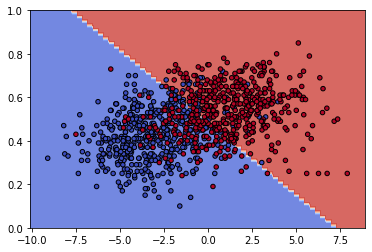

In [249]:
plot_db(x_test, y_test)